### IMAGE ANALYSIS TASK
Working with some sample medical imaging data in the DICOM format and learn how to visualise it and how to do some basic medical image analysis tasks, such as smoothing and segmentation.
DICOM Image source: http://www.pcir.org/researchers/downloads_available.html

### Importing packages
Pydicom is a Python package for working with DICOM files. It allows us to read and easily manipulate DICOM files with the use of Python.

ITK (Insight Segmentation and Registration Toolkit) is a library that enables image processing, and it is widely used for the development of image segmentation and image registration programs. Here, we'll use SimpleITK, as it is a simplified interface to ITK.

The OS module in Python provides a way of using operating system dependent functionality, for instance for working with files and folders.

NumPy is a widely used Python package for working with large, multi-dimensional data (note that here we'll be using it to manipulate pixel data), while Matplotlib is a Python library for plotting data.

In [3]:
import pydicom
import SimpleITK
import os
import numpy
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Part 2: Loading the data
In this programming task we're going to be working with a dataset from an MR examination of a patient's head. The images are captured as DICOM files and they are stored in a folder called 'MyHead'.

Run the code in the following cell to create a list called 'lstFilesDCM', which contains all DICOM files.

In [4]:
PathDicom = "C:\\Users\\sadaf\\66 days of data"
lstFilesDCM = []  # create an empty list
for dirName, subdirList, fileList in os.walk(PathDicom):
    for filename in fileList:
        if ".dcm" in filename.lower():  # check whether the file is DICOM
            lstFilesDCM.append(os.path.join(dirName,filename))

Run the code in the following cell to get the first three elements of the 'lstFilesDCM' list, i.e. the extended names of the first five DICOM files

In [5]:
lstFilesDCM[:3]

['C:\\Users\\sadaf\\66 days of data\\15820.dcm',
 'C:\\Users\\sadaf\\66 days of data\\4919.dcm',
 'C:\\Users\\sadaf\\66 days of data\\5641.dcm']

Reading a DICOM file
Run the code in the following cell to use Pydicom's read_file() function to read the first DICOM file within lstFilesDCM (identified as 'lstFilesDCM[0]'). The resulting object is called 'HeadDs'. Note that we could have called it anything we wanted.

In [6]:
HeadDs = pydicom.read_file(lstFilesDCM[0])

Getting metadata
We can now get metadata of interest for this image with the use of appropriate Pydicom functions (e.g. PatientPosition or Modality).

Run the code in the following cell to get the position of the patient relative to the imaging equipment space.

In [7]:
HeadDs.PatientPosition

'HFS'

HFS stands for Head First-Supine. This means that the patient’s head was positioned toward the front of the imaging equipment and it was in an upward direction.

Run the code in the following cell to get the date the study started. Note that the date format is YYYYMMDD.

In [8]:
HeadDs.StudyDate

'20030505'

In [9]:
HeadDs.Modality

'MR'

## Part 3: Visualisation
Now that we've got an idea of the imaging data that we're going to be working with, we'll visualise the data by creating a two-dimensional plot. But first we'll need to extract some additional information needed for plotting.

Important note: Remember that you don't need to fully understand the code in this programming task. In fact, you could simply reuse the code in Part 3 for a new collection of MR images, given that you've called the list of your DICOM files 'lstFilesDCM' and the first image 'HeadDs'.

Preparing for visualisation
In order to plot the data with Matplotlib, we first need to i) combine the pixel data from all DICOM files (i.e. from all slices) into a 3D dataset, and ii) specify appropriate coordinate axes.

We'll start by calculating the total dimensions of the combined 3D dataset. These should be: (Number of pixel rows in a slice) x (Number of pixel columns in a slice) x (Number of slices) along the x, y, and z cartesian axes. We'll call the calculated dimensions 'CalcPixelDims'.

In [10]:
CalcPixelDims = (int(HeadDs.Rows), int(HeadDs.Columns), len(lstFilesDCM))

Run the code in the following cell to get CalcPixelDims.

In [11]:
CalcPixelDims

(256, 256, 3)

Now that we've calculated the dimensions, we can create a 3D NumPy array to address the first point discussed above. Note that a NumPy array is understood as a grid of values, all of the same type.

The following code creates a NumPy array called 'HeadImgArray' that has the same size as CalcPixelDims, and which contains the pixel data from all DICOM files in lstFilesDCM.

In [12]:
HeadImgArray = numpy.zeros(CalcPixelDims, dtype=HeadDs.pixel_array.dtype)

for filenameDCM in lstFilesDCM:
    ds = pydicom.read_file(filenameDCM)
    HeadImgArray[:, :, lstFilesDCM.index(filenameDCM)] = ds.pixel_array

Now that we've addressed the first point, we move on to specify appropriate coordinate axes.

We use Pydicom's PixelSpacing and SliceThickness functions to calculate the spacing between pixels in the three axes. We call the resulting object 'CalcPixelSpacing'.

In [13]:
CalcPixelSpacing = (float(HeadDs.PixelSpacing[0]), float(HeadDs.PixelSpacing[1]), float(HeadDs.SliceThickness))

Then, we use CalcPixelDims and CalcPixelSpacing to calculate coordinate axes. You don't need to understand what this code does. Just run it to compute x, y and z.

In [14]:
x = numpy.arange(0.0, (CalcPixelDims[0]+1)*CalcPixelSpacing[0], CalcPixelSpacing[0])
y = numpy.arange(0.0, (CalcPixelDims[1]+1)*CalcPixelSpacing[1], CalcPixelSpacing[1])
z = numpy.arange(0.0, (CalcPixelDims[2]+1)*CalcPixelSpacing[2], CalcPixelSpacing[2])

Visualising
We can now plot the data with the use of the pyplot module in matplotlib.

Again, you don't need to understand in detail what this code does. You can simply run it to get a plot of the head MR image. Note that you can modify the number in the last line of the code to get a different slice of the head.



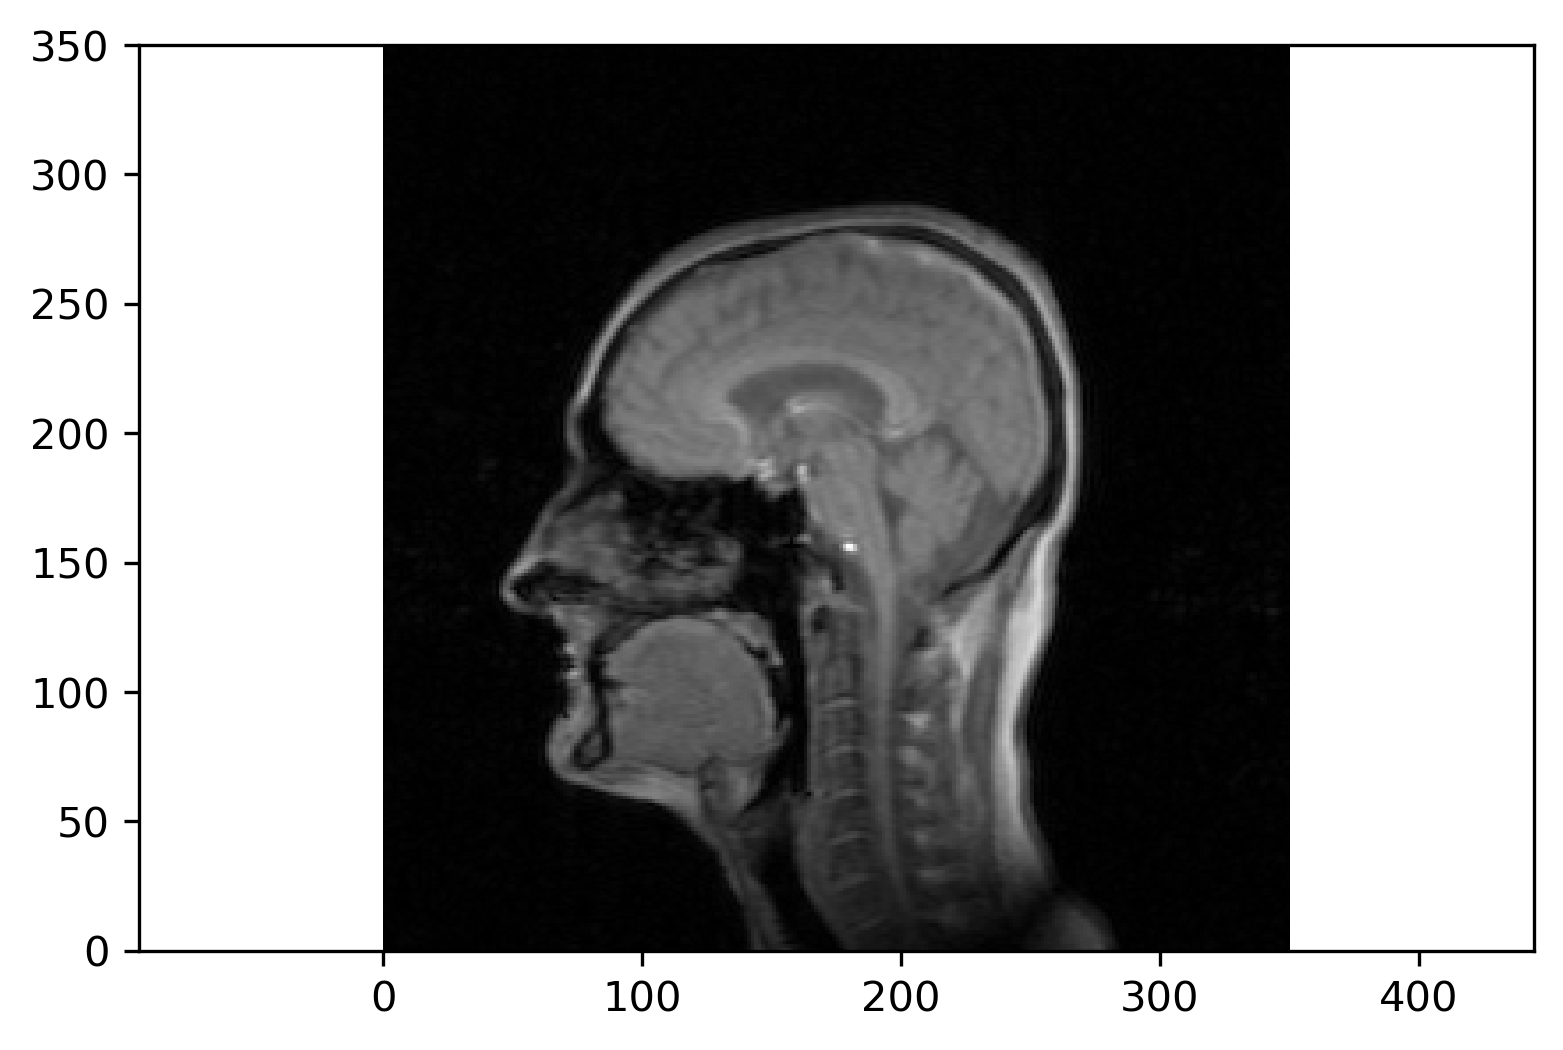

In [15]:
plt.figure(dpi=300)
plt.axes().set_aspect('equal', 'datalim')
plt.set_cmap(plt.gray())
plt.pcolormesh(x, y, numpy.flipud(HeadImgArray[:, :, 1]))

## Part 4: Segmentation
In this part of the notebook we'll use SimpleITK to segment the white and grey matter in the MR images.

Specifying a helper function
We'll be visualising quite a few 2D SimpleITK images in this part, so here we'll define a function that quickly plots a 2D SimpleITK image with a greyscale colourmap and accompanying axes.

In [17]:
def sitk_show(img, title=None, margin=0.05, dpi=40 ):
    nda = SimpleITK.GetArrayFromImage(img)
    spacing = img.GetSpacing()
    figsize = (1 + margin) * nda.shape[0] / dpi, (1 + margin) * nda.shape[1] / dpi
    extent = (0, nda.shape[1]*spacing[1], nda.shape[0]*spacing[0], 0)
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])

    plt.set_cmap("gray")
    ax.imshow(nda,extent=extent,interpolation=None)
    
    if title:
        plt.title(title)
    
    plt.show()

Loading the data in SimpleITK
We now need to tell SimpleITK to read the DICOM files within the 'MyHead' folder. Run the code in the following cell to extract the contents of the MRI dataset and create the corresponding 3D image called 'img3DOriginal'.


In [19]:
reader = SimpleITK.ImageSeriesReader()
filenamesDICOM = reader.GetGDCMSeriesFileNames(PathDicom)
reader.SetFileNames(filenamesDICOM)
img3DOriginal = reader.Execute()

In order to keep things simple, we'll segment a 2D slice of the 3D image (rather than the entire 3D image). Run the code below to specify that we want Z-slice 50 of the 3D image. We'll call this slice 'imgOriginal'.

Note that you could ask for a different Z-slice, if you want.

In [20]:
imgOriginal = img3DOriginal[:,:,0]

Visualising the original data
We'll now call our sitk_show function to visualise the original data.

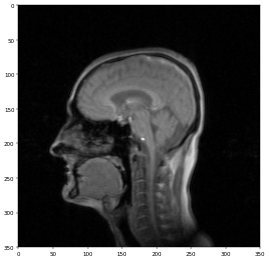

In [21]:
sitk_show(imgOriginal)

Smoothing
Smoothing is the process of reducing noise within an image or producing a less pixelated image. The result is an image with sharp edges or boundaries preserved and smoothing occurring only within a region.

In our case, we can see that the original image data exhibits quite a bit of noise, which is rather typical of MRI datasets. We will reduce the noise, so as to ease the process of segmentation later on.

Run the code in the following cell to apply a Curvature Flow Image Filter to smoothen imgOriginal. We'll call the resulting image 'imgSmooth'.

In [22]:
imgSmooth = SimpleITK.CurvatureFlow(image1=imgOriginal,
                                    timeStep=0.125,
                                    numberOfIterations=5)

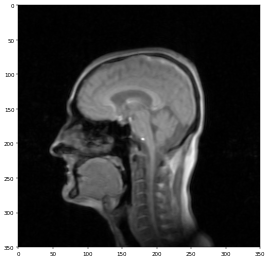

In [23]:
sitk_show(imgSmooth)

#### Segmentation with the ConnectedThreshold filter
We will now apply region growing techniques to segment the white and grey matter of the smoothened image.

Initial segmentation of the white matter
Run the code in the following cell to apply SimpleITK's ConnectedThreshold filter function to imgSmooth. The image of the resulting segmented white matter is called 'imgWhiteMatter'.

As with other parts of this programming task, you don't need to fully understand what this code does. You can simply run it to get the initial segmentation of the white matter.

If, however, you're really curious, here's a brief explanation: This filter starts from a seed point in the image that we know is white matter, and looks at all connected pixels. If their values lie within a range of interest, then they are labelled as white matter. In our case, we've set the seed to be point (150, 75), as by inspecting the previous image, it looked like that point was indeed white matter. We've also set the range of values to be between 130 and 190, as these were roughly the values that the white matter pixels exhibited (this was inspected with the use of a separate DICOM viewing software).

In [24]:
lstSeeds = [(150,75)]

imgWhiteMatter = SimpleITK.ConnectedThreshold(image1=imgSmooth, 
                                              seedList=lstSeeds, 
                                              lower=130, 
                                              upper=190,
                                              replaceValue=1)

In [25]:
imgSmoothInt = SimpleITK.Cast(SimpleITK.RescaleIntensity(imgSmooth), imgWhiteMatter.GetPixelID())

Now let's use SimpleITK's LabelOverlay function to overlay 'imgSmoothInt' and 'imgWhiteMatter', and let's visualise the result.

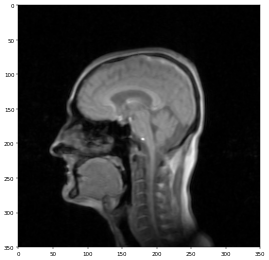

In [26]:
sitk_show(SimpleITK.LabelOverlay(imgSmoothInt, imgWhiteMatter))

Hole-filling of the segmented white matter
As you can see in the figure above, there are several holes in the segmented white matter. We'll rectify this by applying hole-filling.

Run the code in the following cell to use SimpleITK's VotingBinaryHoleFilling filter to fill in holes in imgWhiteMatter. The resulting image is called 'imgWhiteMatterNoHoles'.

In [27]:
imgWhiteMatterNoHoles = SimpleITK.VotingBinaryHoleFilling(image1=imgWhiteMatter,
                                                          radius=[2]*3,
                                                          majorityThreshold=1,
                                                          backgroundValue=0,
                                                          foregroundValue=1)

Now let's use SimpleITK's LabelOverlay function to overlay 'imgSmoothInt' and the newly obtained 'imgWhiteMatterNoHoles', and let's visualise the result.

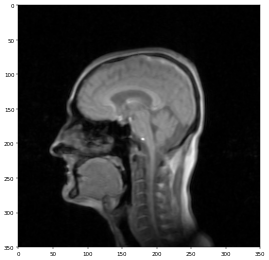

In [28]:
sitk_show(SimpleITK.LabelOverlay(imgSmoothInt, imgWhiteMatterNoHoles))

Segmentation and hole-filling of grey matter
We'll now repeat the process for grey matter. In other words, we'll do some preliminary segmentation and then we'll perform hole-filling of the segmented grey matter. We'll then overlay the 'imgSmoothInt' and the 'imgGreyMatterNoHoles' images and we'll visualise the result.

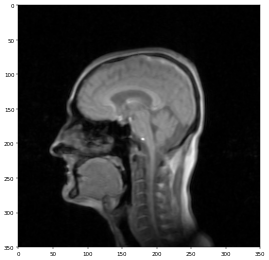

In [29]:
lstSeeds = [(119, 83), (198, 80), (185, 102), (164, 43)]

imgGreyMatter = SimpleITK.ConnectedThreshold(image1=imgSmooth, 
                                             seedList=lstSeeds, 
                                             lower=150, 
                                             upper=270,
                                             replaceValue=2)

imgGreyMatterNoHoles = SimpleITK.VotingBinaryHoleFilling(image1=imgGreyMatter,
                                                         radius=[2]*3,
                                                         majorityThreshold=1,
                                                         backgroundValue=0,
                                                         foregroundValue=2) # labelGrayMatter

sitk_show(SimpleITK.LabelOverlay(imgSmoothInt, imgGreyMatterNoHoles))

Combining the white and grey matter
Lastly, we want to combine the two label-fields, in other words, the white and grey matter. We do this by running the code below, with the results being stored under 'imgLabels'.

In [30]:
imgLabels = imgWhiteMatterNoHoles | imgGreyMatterNoHoles

Now let's use SimpleITK's LabelOverlay function to overlay 'imgSmoothInt' and the newly obtained 'imgLabels', and let's visualise the result.

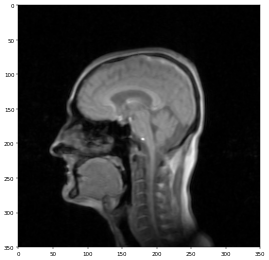

In [31]:
sitk_show(SimpleITK.LabelOverlay(imgSmoothInt, imgLabels))

In [32]:
imgMask = (imgWhiteMatterNoHoles/1) * (imgGreyMatterNoHoles/2)
imgMask2 = SimpleITK.Cast(imgMask, imgWhiteMatterNoHoles.GetPixelIDValue())
imgWhiteMatterNoHoles = imgWhiteMatterNoHoles - (imgMask2*1)
imgLabels2 = imgWhiteMatterNoHoles + imgGreyMatterNoHoles

Now let's use SimpleITK's LabelOverlay function to overlay 'imgSmoothInt' and the newly obtained 'imgLabels2', and let's visualise the result.

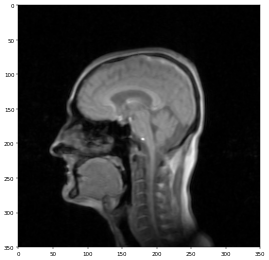

In [33]:
sitk_show(SimpleITK.LabelOverlay(imgSmoothInt, imgLabels2))